<a href="https://colab.research.google.com/github/puzis/llmnet/blob/main/experiments/Distil_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets networkx

In [ ]:
from transformers import AutoTokenizer, DistilBertModel, DistilBertConfig
import torch
import torch.nn as nn
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [ ]:
#distilbert-base-uncased
#distilbert-base-uncased-finetuned-sst-2-english
#fmops/distilbert-prompt-injection
#distilbert-base-multilingual-cased
#lvwerra/distilbert-imdb

In [ ]:
#1
#dataset = load_dataset("glue", "mrpc")
#inputs = dataset['train']['sentence1'][:15]


#2
#dataset = load_dataset("Amod/mental_health_counseling_conversations")
#

In [ ]:
dataset = load_dataset("glue", "mrpc")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
inputs = dataset['train']['sentence1'][:15]
token_arrays = tokenizer(inputs, truncation=True, padding="max_length", return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
class SA_LayerNorm(nn.Module):
    def __init__(self, hidden_size):
        super(SA_LayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, x):
        return self.layer_norm(x)

class DistilBERT(nn.Module):
    def __init__(self, model_name_or_path="distilbert-base-uncased"):
        super(DistilBERT, self).__init__()
        self.config = DistilBertConfig.from_pretrained(model_name_or_path)
        self.distilbert = DistilBertModel.from_pretrained(model_name_or_path, config=self.config)

        # Adding SA_LayerNorm head for each transformer layer
        self.sa_layer_norms = nn.ModuleList([SA_LayerNorm(self.config.dim) for _ in range(self.config.num_hidden_layers)])

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state

        embedding_output = hidden_states

        k_values, v_values, q_values, out_lin_output, ffn_output, output_layer_norm, sa_layer_norm_output = [], [], [], [], [], [], []
        all_hidden_states = [hidden_states]

        for i, layer in enumerate(self.distilbert.transformer.layer):
            k_values.append(layer.attention.k_lin(hidden_states))
            v_values.append(layer.attention.v_lin(hidden_states))
            q_values.append(layer.attention.q_lin(hidden_states))

            out_lin_output.append(layer.attention.out_lin(hidden_states))

            ffn_out = layer.ffn(hidden_states)
            ffn_output.append(ffn_out)

            hidden_states = layer.output_layer_norm(ffn_out + hidden_states)
            output_layer_norm.append(hidden_states)

            # Applying SA_LayerNorm to the last hidden state for each transformer layer
            sa_layer_norm_output.append(self.sa_layer_norms[i](hidden_states))

            all_hidden_states.append(hidden_states)

        # Concatenate outputs along dim=0
        concatenated_output = torch.cat([
            embedding_output,
        ], dim=0)

        for i in range(len(self.distilbert.transformer.layer)):
            concatenated_output = torch.cat([
                concatenated_output,
                k_values[i],
                v_values[i],
                q_values[i],
                out_lin_output[i],
                output_layer_norm[i],
                sa_layer_norm_output[i],
                ffn_output[i]
            ], dim=0)

          # Delete variables after use
        del k_values[i], v_values[i], q_values[i], out_lin_output[i], output_layer_norm[i], sa_layer_norm_output[i], ffn_output[i], hidden_states


        return concatenated_output

In [ ]:
with torch.no_grad():
    model = DistilBERT().cuda()
    output = model(**token_arrays.to('cuda'))
    output = output.view(-1, 768*43, 512)
    tensor = torch.cat((torch.empty(0).cuda(), output), dim=1)
    tensor = tensor.reshape(33024, 15*512)
    corr = torch.corrcoef(tensor)

In [ ]:
del dataset
del inputs
del tensor
del tokenizer
del token_arrays
del output
del model
torch.cuda.empty_cache()

In [ ]:
#degree distribution of each node
degree_distribution = torch.sum(corr, dim=0)

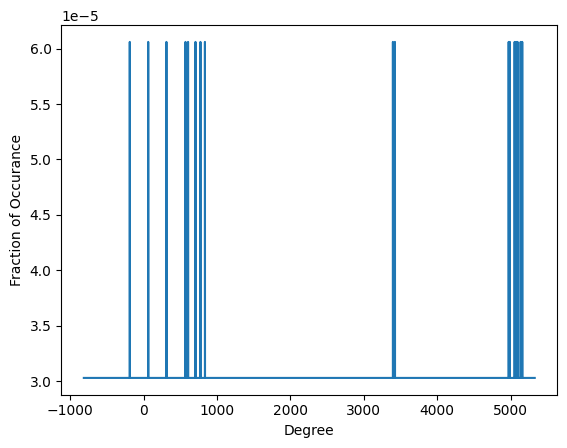

In [ ]:
#Fraction of occurance vs Degree
values, counts = np.unique(degree_distribution.cpu().numpy(), return_counts=True)
plt.plot(values, counts/len(counts))
plt.xlabel('Degree')
plt.ylabel('Fraction of Occurance')
plt.show()

In [ ]:
#fraction of node vs degree distribution
degree_counts = torch.bincount(degree_distribution[degree_distribution >= 0].int())
degree_fractions = degree_counts / degree_distribution.shape[0]

plt.figure(figsize=(10, 6))
plt.plot(degree_fractions)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.grid(True)
plt.show()

In [ ]:
#node vs degree distribution
plt.figure(figsize=(10,6))
plt.plot(degree_distribution.cpu().numpy())
plt.title('Linear Node vs Degree Distribution')
plt.xlabel('Node')
plt.ylabel('Degree')
plt.grid(True)
plt.show()


In [ ]:
#log-log degree distribution
plt.figure(figsize=(10,6))
plt.loglog(degree_distribution.cpu().numpy())
plt.title('Log-Log Node vs Degree Distribution')
plt.xlabel('Node')
plt.ylabel('Degree')
plt.grid(True)
plt.show()

In [ ]:
#semi-log degree distribution
plt.figure(figsize=(10,6))
plt.semilogy(degree_distribution.cpu().numpy())
plt.title('Semi-Log Node vs Degree Distribution')
plt.xlabel('Node')
plt.ylabel('Degree')
plt.grid(True)
plt.show()

In [ ]:
flattened_matrix = corr.flatten().cpu().numpy()
threshold = np.percentile(flattened_matrix, 98)

In [ ]:
mask = corr > threshold
edges = torch.nonzero(mask, as_tuple=False)
edges = torch.unique(edges, dim=0)

In [ ]:
del flattened_matrix
del mask
del threshold
del corr
torch.cuda.empty_cache()

In [ ]:
edges = edges.cpu().numpy()

In [ ]:
#create graph
G = nx.Graph()
for edge in edges:
    G.add_edge(*edge)
del edges
del edge
G.remove_edges_from(nx.selfloop_edges(G))

In [ ]:
#rich club
rc = nx.rich_club_coefficient(G_undirected, normalized=False, seed=42)
degrees = list(rc.keys())
coefficients = list(rc.values())
plt.plot(degrees, coefficients)
plt.show()